In [ ]:
# --- Impor Pustaka ---
# Mengimpor semua pustaka yang diperlukan untuk analisis data, preprocessing,
# pemodelan, evaluasi, dan visualisasi.

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# --- Memuat Aset ---
# Memuat dataset yang sudah diproses sebelumnya (hasil dari seleksi fitur).

df = pd.read_csv('../Data/Bot_IoT_processedV3.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26265 entries, 0 to 26264
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   proto_udp  26265 non-null  float64
 1   proto_tcp  26265 non-null  float64
 2   bytes      26265 non-null  int64  
 3   state_RST  26265 non-null  float64
 4   sbytes     26265 non-null  int64  
 5   dport      26265 non-null  int64  
 6   state_CON  26265 non-null  float64
 7   dur        26265 non-null  float64
 8   rate       26265 non-null  float64
 9   pkts       26265 non-null  int64  
 10  attack     26265 non-null  int64  
dtypes: float64(6), int64(5)
memory usage: 2.2 MB


In [4]:
df.head()

,proto_udp,proto_tcp,bytes,state_RST,sbytes,dport,state_CON,dur,rate,pkts,attack
0,1.0,0.0,176,0.0,176,8976,0.0,5.047946,0.198100,2,0
1,0.0,1.0,120,1.0,60,11459,0.0,0.000114,8771.929688,2,1
2,0.0,1.0,120,1.0,60,1648,0.0,0.033741,29.637531,2,1
3,0.0,1.0,120,1.0,60,3718,0.0,0.032499,30.770178,2,1
4,0.0,1.0,662,1.0,456,2395,0.0,0.000244,20491.802734,6,1


In [ ]:
# --- Definisi Tipe Kolom ---
# Mendefinisikan secara manual daftar kolom yang bersifat numerik murni.
# Kolom lainnya (selain numerik dan target 'attack') secara otomatis dianggap kategorikal.
# Ini penting untuk memastikan proses scaling hanya diterapkan pada kolom numerik.

num_cols_list = ['bytes', 'sbytes', 'dur', 'rate', 'pkts']
categorical_cols_list = [col for col in df.columns if col not in num_cols_list and col != 'attack']
print(categorical_cols_list)

['proto_udp', 'proto_tcp', 'state_RST', 'dport', 'state_CON']


In [ ]:
# --- Pemisahan Fitur dan Target ---
# Memisahkan DataFrame menjadi dua bagian:
# X: Matriks fitur yang berisi semua kolom input untuk model.
# y: Vektor target yang berisi label 'attack' yang ingin diprediksi.

X = df.drop('attack', axis=1)
y = df['attack']

In [ ]:
# --- Pemisahan Data Latih dan Uji (Train-Test Split) ---
# Membagi dataset menjadi 80% untuk pelatihan dan 20% untuk pengujian.
# `stratify=y` digunakan untuk memastikan proporsi kelas 'attack' dan 'normal'
# sama di kedua set, yang sangat penting untuk data tidak seimbang.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Ukuran set latih: {X_train.shape}")
print(f"Ukuran set uji: {X_test.shape}\n")

Ukuran set latih: (21012, 10)
Ukuran set uji: (5253, 10)



In [ ]:
# --- Normalisasi Data (Scaling) ---
# Menerapkan StandardScaler untuk mengubah skala fitur-fitur numerik.
# 1. Scaler dilatih (fit) hanya pada data latih numerik untuk mempelajari parameter scaling.
# 2. Aturan scaling yang sama kemudian diterapkan (transform) ke data latih dan data uji numerik.
# 3. Data numerik yang sudah di-scale digabungkan kembali dengan data kategorikal.

scaler = StandardScaler()

# Pisahkan kolom numerik dan kategorikal
X_train_num = X_train[num_cols_list]
X_train_cat = X_train[categorical_cols_list]
X_test_num = X_test[num_cols_list]
X_test_cat = X_test[categorical_cols_list]

# Latih dan terapkan scaler pada data latih numerik
X_train_num_scaled = scaler.fit_transform(X_train_num)

# Terapkan scaler yang sama pada data uji numerik
X_test_num_scaled = scaler.transform(X_test_num)

# Ubah kembali ke DataFrame untuk menjaga struktur
X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, index=X_train.index, columns=num_cols_list)
X_test_num_scaled_df = pd.DataFrame(X_test_num_scaled, index=X_test.index, columns=num_cols_list)

# Gabungkan kembali dengan kolom kategorikal
X_train_scaled = pd.concat([X_train_num_scaled_df, X_train_cat], axis=1)
X_test_scaled = pd.concat([X_test_num_scaled_df, X_test_cat], axis=1)

In [ ]:
# --- Pemisahan Data Latih dan Evaluasi ---
# Membagi data latih yang sudah di-scale menjadi dua bagian:
# 1. Set Latih Final (80%): Untuk melatih model secara langsung.
# 2. Set Evaluasi (20%): Untuk memonitor performa model selama pelatihan (misal, untuk early stopping).

X_train_final, X_eval, y_train_final, y_eval = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [ ]:
# --- Penyeimbangan Data Latih dengan SMOTE ---
#
# Menerapkan Synthetic Minority Over-sampling Technique (SMOTE) untuk mengatasi 
# masalah ketidakseimbangan kelas pada data latih. Sesuai dengan penelitian oleh 
# Ghaderzadeh, Aria, & Asadi (2021), SMOTE efektif untuk menyeimbangkan dataset 
# keamanan siber seperti Bot-IoT. Teknik ini membuat sampel sintetis pada kelas 
# minoritas ('normal') agar jumlahnya setara dengan kelas mayoritas.
#
# Referensi: DOI 10.3390/info14100550
#

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_final, y_train_final)

# Menampilkan perbandingan distribusi kelas sebelum dan sesudah SMOTE
print(f"Distribusi kelas data latih final SEBELUM SMOTE:\n{y_train_final.value_counts()}")
print(f"Distribusi kelas data latih final SETELAH SMOTE:\n{y_train_resampled.value_counts()}\n")
print(f"Ukuran set latih setelah SMOTE: {X_train_resampled.shape}\n")

Distribusi kelas data latih final SEBELUM SMOTE:
attack
1    12762
0     4047
Name: count, dtype: int64
Distribusi kelas data latih final SETELAH SMOTE:
attack
1    12762
0    12762
Name: count, dtype: int64

Ukuran set latih setelah SMOTE: (25524, 10)



In [11]:
print(f"Distribusi kelas data test:\n{y_test.value_counts()}\n")

Distribusi kelas data test:
attack
1    3988
0    1265
Name: count, dtype: int64



In [ ]:
# --- Inisialisasi Model Klasifikasi (XGBoost) ---
#
# Memilih XGBoost sebagai model klasifikasi utama. Penelitian oleh Ghaderzadeh, 
# Aria, & Asadi (2021) menunjukkan bahwa XGBoost memberikan performa yang superior 
# untuk klasifikasi serangan pada dataset Bot-IoT, terutama setelah penyeimbangan data.
#
# Referensi: DOI 10.3390/info14100550
#
# Parameter model diatur sebagai berikut:
# - objective='binary:logistic': Mengindikasikan masalah klasifikasi biner.
# - eval_metric='logloss': Metrik untuk memonitor performa selama validasi.
# - n_estimators=1000: Batas maksimum putaran/pohon yang akan dibangun.
# - early_stopping_rounds=10: Mekanisme untuk menghentikan pelatihan jika tidak ada
#                             peningkatan performa selama 10 putaran berturut-turut
#                             untuk mencegah overfitting.
#

model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=1000, 
    use_label_encoder=False,
    random_state=42,
    early_stopping_rounds=10
)

In [ ]:
# --- Pelatihan Model ---
# Melatih model XGBoost menggunakan data latih yang sudah di-SMOTE.
# eval_set digunakan untuk memonitor performa pada data evaluasi di setiap putaran,
# yang memungkinkan mekanisme early stopping untuk bekerja.

model.fit(
    X_train_resampled, 
    y_train_resampled,
    eval_set=[(X_eval, y_eval)],
    verbose=True # Menampilkan logloss di setiap putaran.
)

[0]	validation_0-logloss:0.43931
[1]	validation_0-logloss:0.29909
[2]	validation_0-logloss:0.21067
[3]	validation_0-logloss:0.15163
[4]	validation_0-logloss:0.11071
[5]	validation_0-logloss:0.08180
[6]	validation_0-logloss:0.06097
[7]	validation_0-logloss:0.04616
[8]	validation_0-logloss:0.03550
[9]	validation_0-logloss:0.02750
[10]	validation_0-logloss:0.02163
[11]	validation_0-logloss:0.01719
[12]	validation_0-logloss:0.01405
[13]	validation_0-logloss:0.01148
[14]	validation_0-logloss:0.00959
[15]	validation_0-logloss:0.00819
[16]	validation_0-logloss:0.00719
[17]	validation_0-logloss:0.00637
[18]	validation_0-logloss:0.00572
[19]	validation_0-logloss:0.00520
[20]	validation_0-logloss:0.00482
[21]	validation_0-logloss:0.00445
[22]	validation_0-logloss:0.00430
[23]	validation_0-logloss:0.00407
[24]	validation_0-logloss:0.00394
[25]	validation_0-logloss:0.00381
[26]	validation_0-logloss:0.00383
[27]	validation_0-logloss:0.00381
[28]	validation_0-logloss:0.00364
[29]	validation_0-loglos

c:\Users\albia\anaconda3\envs\pytorch_env\lib\site-packages\xgboost\callback.py:386: UserWarning: [19:03:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
# --- Prediksi ---
# Menggunakan model yang sudah dilatih untuk membuat prediksi pada data uji (X_test_scaled)
# yang belum pernah dilihat oleh model selama proses pelatihan.

y_pred = model.predict(X_test_scaled)

Laporan Klasifikasi Lengkap:
              precision    recall  f1-score   support

           0     0.9976    0.9976    0.9976      1265
           1     0.9992    0.9992    0.9992      3988

    accuracy                         0.9989      5253
   macro avg     0.9984    0.9984    0.9984      5253
weighted avg     0.9989    0.9989    0.9989      5253

Confusion Matrix:
[[1262    3]
 [   3 3985]]


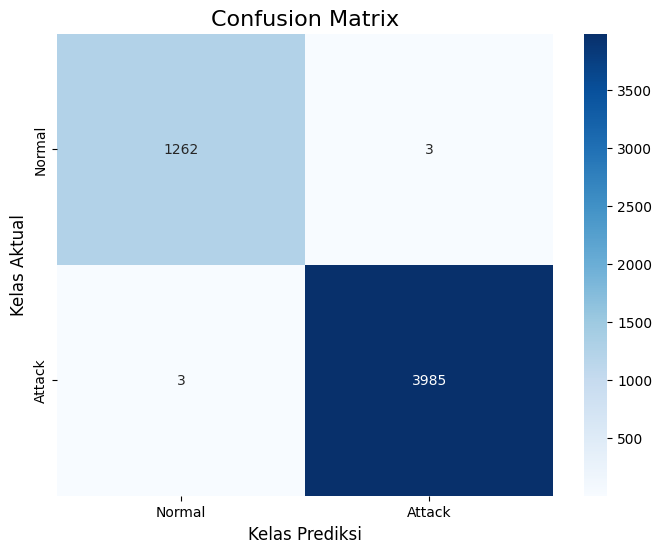

In [22]:
# --- Evaluasi Performa Model ---
# Menampilkan metrik evaluasi untuk melihat seberapa baik performa model.
# Laporan klasifikasi memberikan rincian precision, recall, dan f1-score.
# Confusion matrix menunjukkan jumlah prediksi yang benar dan salah secara absolut.

# Menampilkan Laporan Klasifikasi dengan 4 desimal untuk presisi lebih
print("Laporan Klasifikasi Lengkap:")
print(classification_report(y_test, y_pred, digits=4))

# Menampilkan Confusion Matrix dalam bentuk heatmap untuk visualisasi yang lebih baik
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Attack'], 
            yticklabels=['Normal', 'Attack'])
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Kelas Aktual', fontsize=12)
plt.xlabel('Kelas Prediksi', fontsize=12)
plt.show()

In [ ]:
# --- Penyimpanan Model ---
# Menyimpan objek model yang sudah dilatih ke dalam sebuah file menggunakan joblib.
# Ini memungkinkan model untuk dimuat dan digunakan kembali di masa depan
# tanpa perlu mengulang proses pelatihan yang memakan waktu.

import joblib

# Simpan objek model ke dalam file .pkl
joblib.dump(model, '../Model/xgboost_botnet_detector.pkl')

['../Model/xgboost_botnet_detector.pkl']